# Seasonal Comparison: Watching Vegetation Change Through the Year

In the previous notebook, we looked at a single snapshot in time. But one of the most powerful aspects of satellite data is its **temporal dimension** — the same satellite passes over the same location repeatedly.

**What we'll do:**
1. Load imagery from Summer 2024 and Winter 2024 for the same location
2. Compare true color images side-by-side
3. Compare NDVI to see vegetation health changes
4. Understand what drives these seasonal patterns

**Key insight:** Vegetation follows predictable seasonal cycles. In temperate regions:
- **Summer:** High NDVI (green, actively growing)
- **Winter:** Low NDVI (dormant, brown, or snow-covered)

---
## 1. Setup

In [1]:
from pystac_client import Client
import planetary_computer as pc
from odc.stac import stac_load

import numpy as np
import matplotlib.pyplot as plt

# Connect to Planetary Computer
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
print("Connected to Planetary Computer")

/Users/hds-altec009/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Connected to Planetary Computer


---
## 2. Define Location and Helper Functions

We'll use the same area you explored before. Feel free to change this to any location!

In [2]:
# Same bbox as your previous exploration
# Format: [min_lon, min_lat, max_lon, max_lat]
bbox = [-105.00046265789766, 40.61040537905372, -104.97822774714184, 40.62419090978705]

print(f"Area of interest:")
print(f"  Longitude: {bbox[0]:.4f} to {bbox[2]:.4f}")
print(f"  Latitude:  {bbox[1]:.4f} to {bbox[3]:.4f}")

Area of interest:
  Longitude: -105.0005 to -104.9782
  Latitude:  40.6104 to 40.6242


In [4]:
def normalize(img, pmin=2, pmax=98):
    """Normalize image to 0-1 range using percentiles."""
    lo, hi = np.nanpercentile(img, [pmin, pmax])
    return np.clip((img - lo) / (hi - lo + 1e-6), 0, 1)

def compute_ndvi(nir, red):
    """Compute NDVI from NIR and Red bands."""
    return (nir - red) / (nir + red + 1e-6)

def load_satellite_image(catalog, bbox, date_range, max_cloud_cover=20):
    """
    Search for and load a Sentinel-2 image.
    Returns the xarray dataset and metadata about the selected image.
    """
    # Search for images
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox,
        datetime=date_range,
        query={"eo:cloud_cover": {"lt": max_cloud_cover}},
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        raise ValueError(f"No images found for {date_range} with <{max_cloud_cover}% clouds")
    
    # Select best (lowest cloud cover) image
    items_sorted = sorted(items, key=lambda x: x.properties.get('eo:cloud_cover', 100))
    item = items_sorted[0]
    
    # Sign and load
    signed_item = pc.sign(item)
    data = stac_load(
        [signed_item],
        bands=["B02", "B03", "B04", "B08"],
        bbox=bbox,
        crs="EPSG:4326",
        resolution=0.0001,
        groupby="solar_day",
    )
    
    metadata = {
        'date': item.datetime,
        'cloud_cover': item.properties.get('eo:cloud_cover', 'N/A'),
        'id': item.id
    }
    
    return data, metadata

print("Helper functions defined.")

Helper functions defined.


---
## 3. Load Summer Image (Peak Growing Season)

July-August is typically when vegetation is most active in the Northern Hemisphere. Plants are photosynthesizing heavily, producing high NDVI values.

In [5]:
# Load summer image
summer_data, summer_meta = load_satellite_image(
    catalog, 
    bbox, 
    date_range="2024-07-01/2024-08-31"
)

print(f"Summer image:")
print(f"  Date: {summer_meta['date']}")
print(f"  Cloud cover: {summer_meta['cloud_cover']:.2f}%")

Summer image:
  Date: 2024-07-31 17:39:11.024000+00:00
  Cloud cover: 0.00%


---
## 4. Load Winter Image (Dormant Season)

January-February in Colorado typically shows:
- Snow cover (appears white/bright in all bands)
- Dormant brown vegetation
- Very low NDVI values

**Note:** We increase cloud cover tolerance since winter imagery can be harder to find cloud-free.

In [6]:
# Load winter image (allow more clouds since winter is tricky)
winter_data, winter_meta = load_satellite_image(
    catalog, 
    bbox, 
    date_range="2024-01-01/2024-02-28",
    max_cloud_cover=30
)

print(f"Winter image:")
print(f"  Date: {winter_meta['date']}")
print(f"  Cloud cover: {winter_meta['cloud_cover']:.2f}%")

Winter image:
  Date: 2024-01-31 17:55:59.024000+00:00
  Cloud cover: 0.00%


---
## 5. Process Both Images

Create RGB composites and compute NDVI for both seasons.

In [7]:
# Process summer
summer_rgb = normalize(np.stack([
    summer_data["B04"].isel(time=0).values,
    summer_data["B03"].isel(time=0).values,
    summer_data["B02"].isel(time=0).values,
], axis=-1))

summer_ndvi = compute_ndvi(
    summer_data["B08"].isel(time=0).values.astype("float32"),
    summer_data["B04"].isel(time=0).values.astype("float32")
)

# Process winter
winter_rgb = normalize(np.stack([
    winter_data["B04"].isel(time=0).values,
    winter_data["B03"].isel(time=0).values,
    winter_data["B02"].isel(time=0).values,
], axis=-1))

winter_ndvi = compute_ndvi(
    winter_data["B08"].isel(time=0).values.astype("float32"),
    winter_data["B04"].isel(time=0).values.astype("float32")
)

print("Summer NDVI - Mean: {:.2f}, Range: [{:.2f}, {:.2f}]".format(
    np.nanmean(summer_ndvi), np.nanmin(summer_ndvi), np.nanmax(summer_ndvi)))
print("Winter NDVI - Mean: {:.2f}, Range: [{:.2f}, {:.2f}]".format(
    np.nanmean(winter_ndvi), np.nanmin(winter_ndvi), np.nanmax(winter_ndvi)))

Summer NDVI - Mean: 0.21, Range: [-0.09, 0.57]
Winter NDVI - Mean: 0.11, Range: [-0.19, 0.49]


---
## 6. True Color Comparison

Side-by-side view of what the landscape looks like in each season.

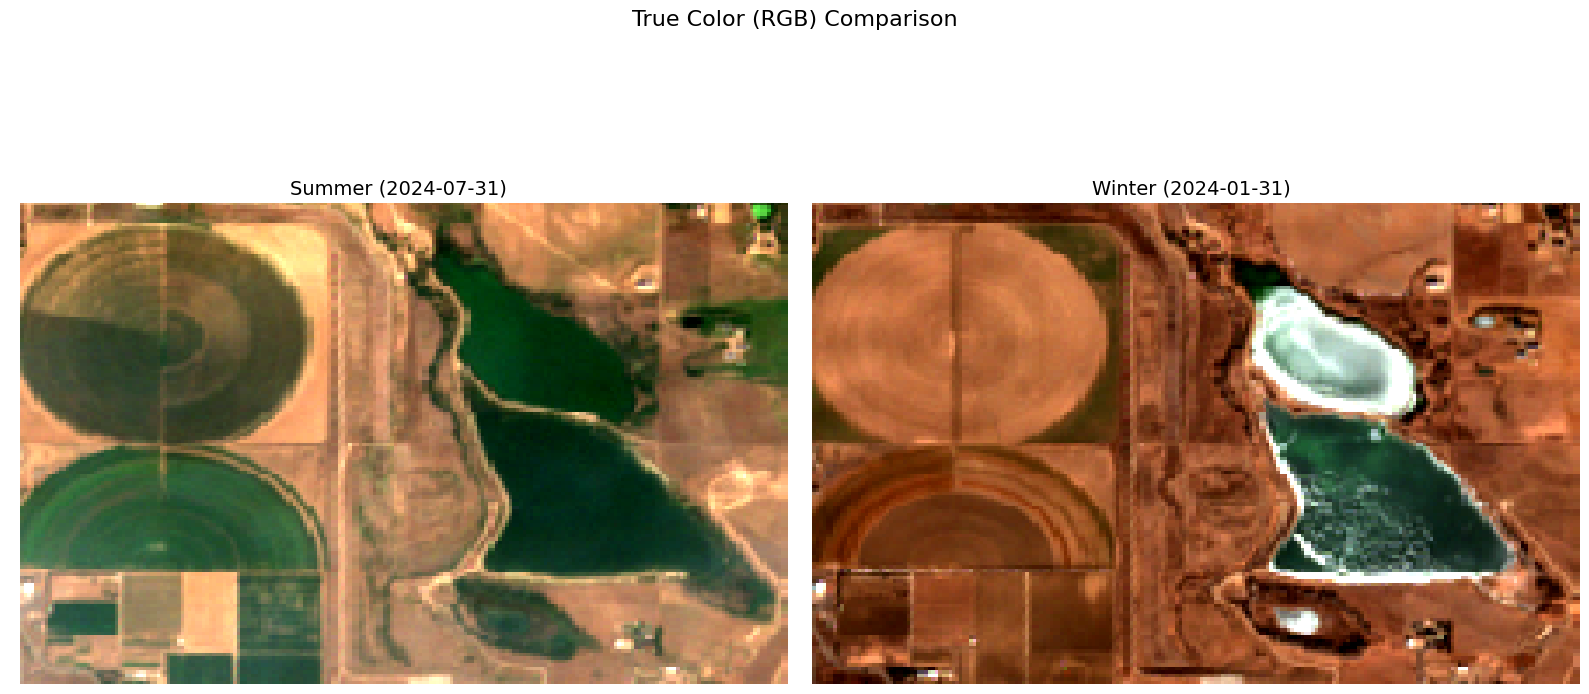

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(summer_rgb)
axes[0].set_title(f"Summer ({summer_meta['date'].strftime('%Y-%m-%d')})", fontsize=14)
axes[0].axis("off")

axes[1].imshow(winter_rgb)
axes[1].set_title(f"Winter ({winter_meta['date'].strftime('%Y-%m-%d')})", fontsize=14)
axes[1].axis("off")

plt.suptitle("True Color (RGB) Comparison", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### What to Look For

**Summer:**
- Green agricultural fields
- Dark green trees/forests
- Brown dry areas

**Winter:**
- White/bright areas = snow cover
- Brown dormant vegetation
- Evergreen trees may still appear dark green

---
## 7. NDVI Comparison

This is where the seasonal difference becomes dramatic. NDVI quantifies the vegetation health we can barely see in true color.

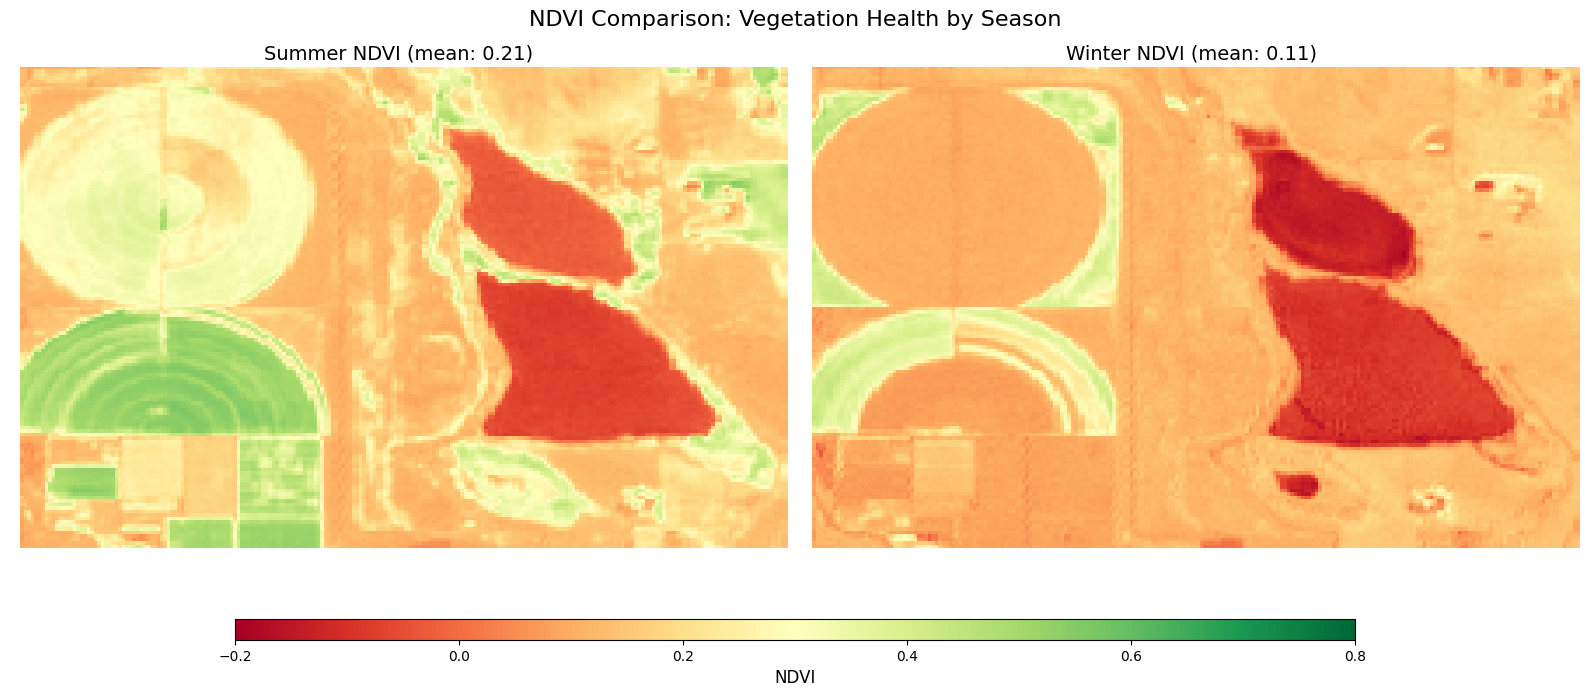

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Use the same color scale for fair comparison
vmin, vmax = -0.2, 0.8

im0 = axes[0].imshow(summer_ndvi, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[0].set_title(f"Summer NDVI (mean: {np.nanmean(summer_ndvi):.2f})", fontsize=14)
axes[0].axis("off")

im1 = axes[1].imshow(winter_ndvi, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[1].set_title(f"Winter NDVI (mean: {np.nanmean(winter_ndvi):.2f})", fontsize=14)
axes[1].axis("off")

plt.suptitle("NDVI Comparison: Vegetation Health by Season", fontsize=16)
plt.tight_layout()

# Add horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label("NDVI", fontsize=12)
cbar.set_ticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])

plt.subplots_adjust(bottom=0.18)
plt.show()

### Interpreting the NDVI Comparison

The difference should be striking:

**Summer NDVI:**
- Agricultural areas show high NDVI (0.4-0.8) — crops actively growing
- Natural vegetation is photosynthesizing

**Winter NDVI:**
- Most areas show low NDVI (< 0.2)
- Snow-covered areas can show negative NDVI (snow reflects both red and NIR similarly)
- Only evergreen forests maintain moderate NDVI year-round

---
## 8. NDVI Difference Map

Let's compute where vegetation changed the most between seasons.

In [10]:
# Compute difference: positive = summer greener, negative = winter greener (rare)
ndvi_diff = summer_ndvi - winter_ndvi

print(f"NDVI Change Statistics:")
print(f"  Mean change: {np.nanmean(ndvi_diff):.2f}")
print(f"  Max increase (summer greener): {np.nanmax(ndvi_diff):.2f}")
print(f"  Max decrease (winter greener): {np.nanmin(ndvi_diff):.2f}")

NDVI Change Statistics:
  Mean change: 0.10
  Max increase (summer greener): 0.50
  Max decrease (winter greener): -0.38


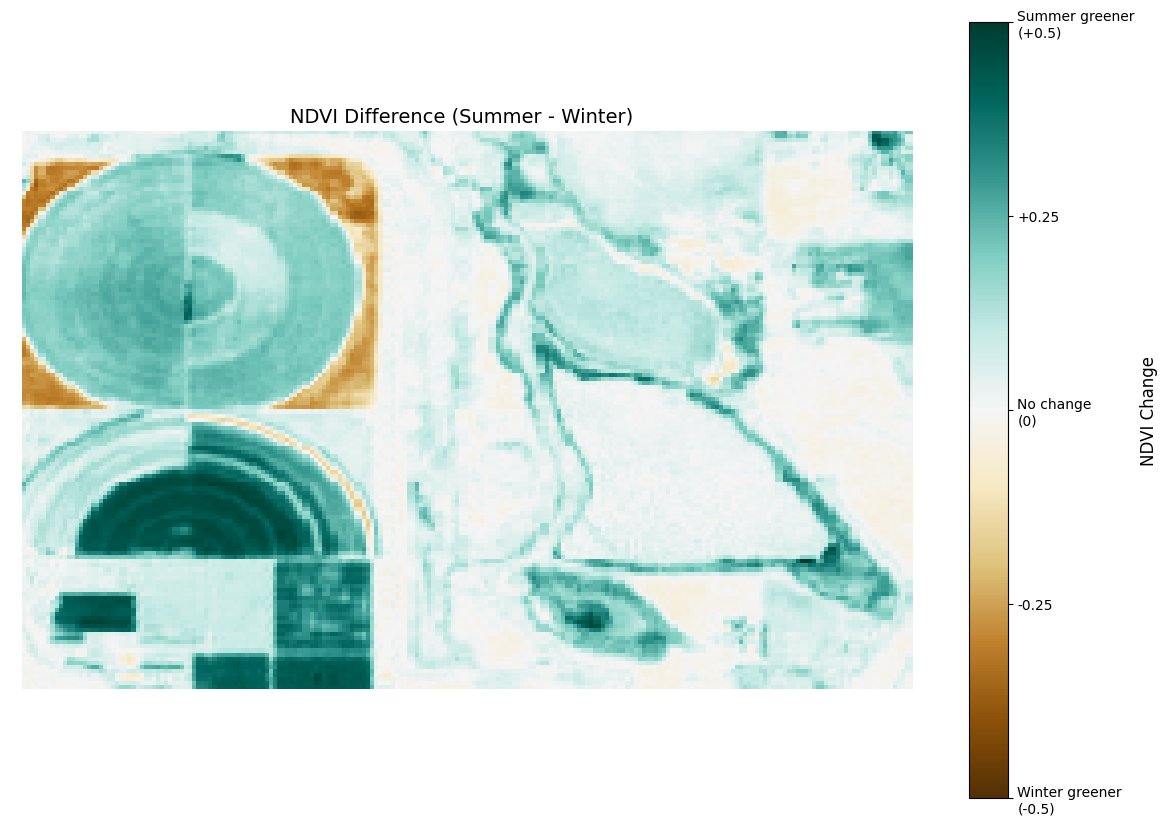

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))

# Diverging colormap: brown = winter greener, teal/green = summer greener
im = ax.imshow(ndvi_diff, cmap='BrBG', vmin=-0.5, vmax=0.5)
ax.set_title("NDVI Difference (Summer - Winter)", fontsize=14)
ax.axis("off")

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("NDVI Change", fontsize=12)
cbar.set_ticks([-0.5, -0.25, 0, 0.25, 0.5])
cbar.set_ticklabels(['Winter greener\n(-0.5)', '-0.25', 'No change\n(0)', '+0.25', 'Summer greener\n(+0.5)'])

plt.tight_layout()
plt.show()

### Interpreting the Difference Map

- **Green/teal areas:** Large seasonal vegetation change — these are likely agricultural fields or deciduous vegetation
- **Brown areas:** Relatively stable or winter had more vegetation (unusual)
- **White/neutral areas:** Similar NDVI in both seasons — could be:
  - Evergreen forests (always green)
  - Urban areas (always low)
  - Water bodies (always low/negative)

---
## 9. Full Comparison Grid

All four views together for easy comparison.

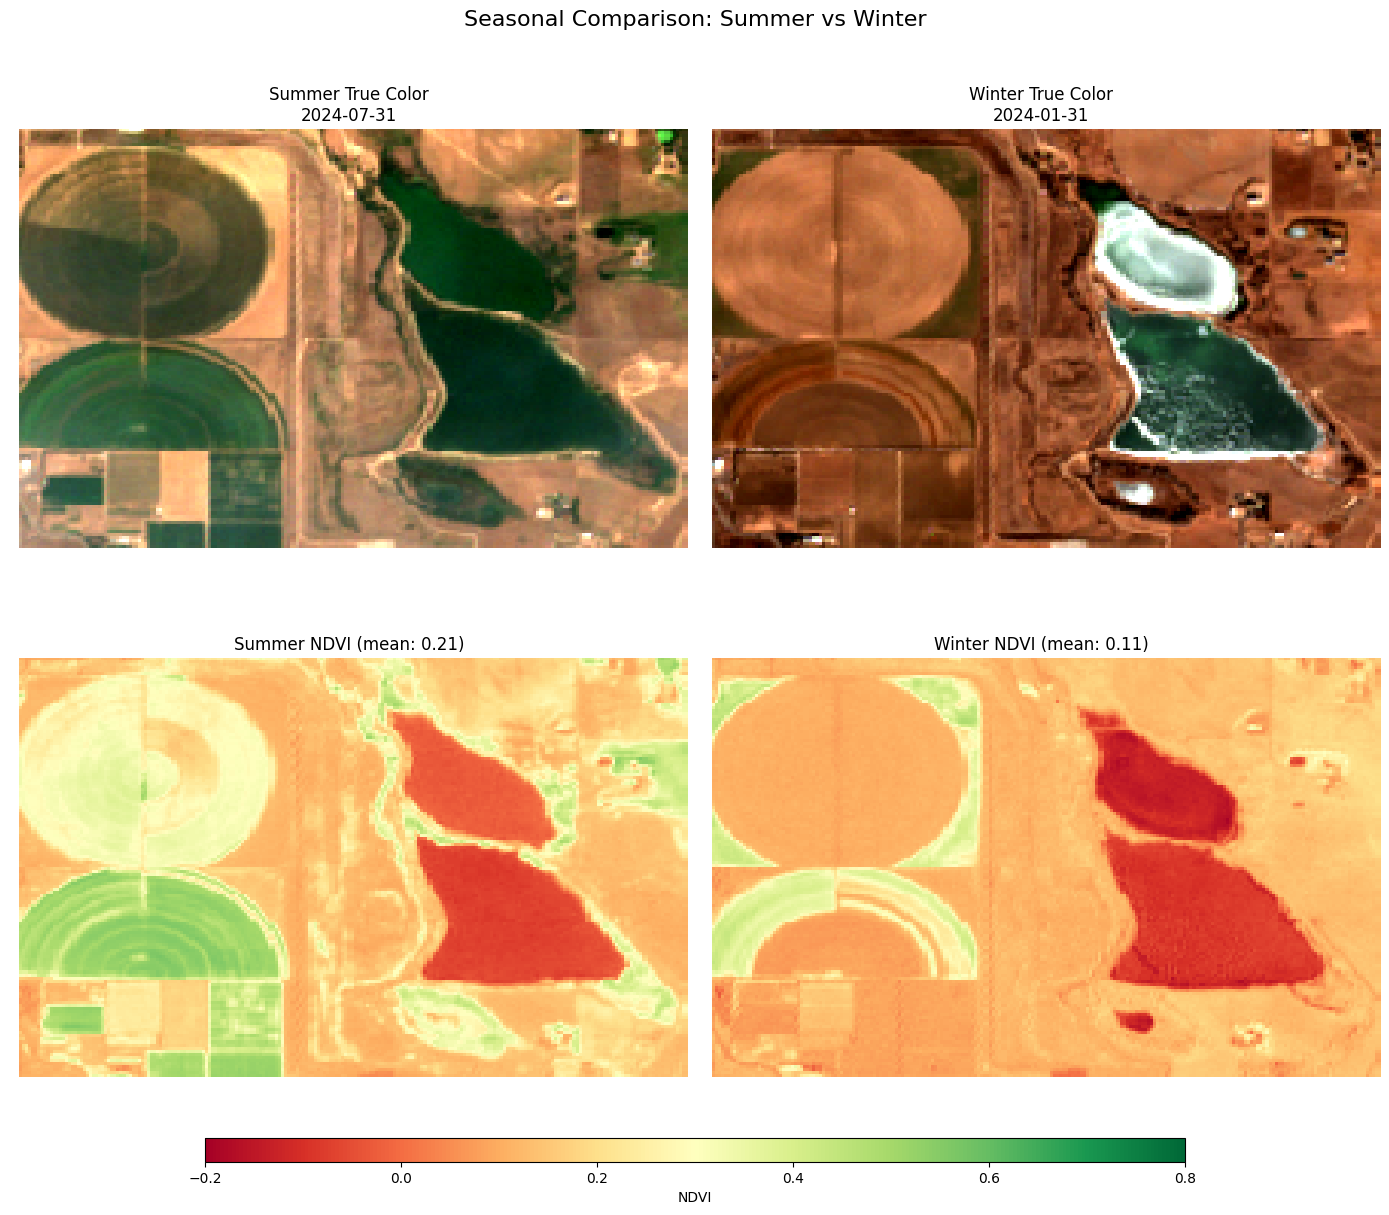

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Summer RGB
axes[0, 0].imshow(summer_rgb)
axes[0, 0].set_title(f"Summer True Color\n{summer_meta['date'].strftime('%Y-%m-%d')}", fontsize=12)
axes[0, 0].axis("off")

# Winter RGB
axes[0, 1].imshow(winter_rgb)
axes[0, 1].set_title(f"Winter True Color\n{winter_meta['date'].strftime('%Y-%m-%d')}", fontsize=12)
axes[0, 1].axis("off")

# Summer NDVI
im_summer = axes[1, 0].imshow(summer_ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[1, 0].set_title(f"Summer NDVI (mean: {np.nanmean(summer_ndvi):.2f})", fontsize=12)
axes[1, 0].axis("off")

# Winter NDVI
im_winter = axes[1, 1].imshow(winter_ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[1, 1].set_title(f"Winter NDVI (mean: {np.nanmean(winter_ndvi):.2f})", fontsize=12)
axes[1, 1].axis("off")

plt.suptitle("Seasonal Comparison: Summer vs Winter", fontsize=16)
plt.tight_layout()

# Add colorbar below the NDVI row, spanning both columns
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im_winter, cax=cbar_ax, orientation='horizontal', label="NDVI")
cbar.set_ticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])

plt.show()


---
## Summary

**What we learned:**

1. **Temporal analysis** is a key strength of satellite data — the same sensor passes over regularly, allowing change detection

2. **Seasonal vegetation cycles** are clearly visible:
   - Summer: High NDVI, active photosynthesis
   - Winter: Low NDVI, dormancy or snow cover

3. **Different land cover types** respond differently to seasons:
   - Agricultural fields: Dramatic seasonal swing
   - Evergreen forests: Relatively stable
   - Urban areas: Always low NDVI

4. **Difference maps** highlight where change occurred — useful for detecting:
   - Agricultural activity
   - Deforestation
   - Urban expansion
   - Drought impacts

**Next explorations:**
- Create a full year time series (monthly images)
- Compare a drought year to a normal year
- Look at a fire scar before/after